---
# Ames Housing: Price Prediction Using Linear Regression Model
---

## Content
- Background
- Data Cleaning
- Exploratory Data Analysis (EDA)
- Base Model
- Model Optimisation
- Conclusions and Recommendations

## Background

Property sale transactions have always been heavily reliant, both formally and informally, by the size of their total land area and the use of features such as the number of bedroom and bathrooms as a gauge to try to measure it. Our data science team from Kishan Analytics is proposing the use a of other housing features to build an regression accurate model for predicting home values in Ames. Our aim is to identify other housing features that contribute significantly to sale prices so that real estate agents can make use of our analyses and prediction models to help their client secure the best price for their properties.

The knowledge that property prices tend to fluctuate is not new. These research have explored reasons from socioeconomic policies that affected the supply-demand cycle ([*Source*](https://www.economicshelp.org/blog/377/housing/factors-that-affect-the-housing-market/)) to individual psychological factors ([*Source*](https://www.jstor.org/stable/pdf/24920966.pdf)) to structural features of the houses ([*Source*](https://www.opendoor.com/w/blog/factors-that-influence-home-value)). Our model is based on the latter category of housing features as they are slightly more controllable than the other considerations mentioned above prior to the point of sale and could hence be developed into a more reliable predictive model.

### Datasets

This project uses the Ames housing data available on [*Kaggle*](https://www.kaggle.com/c/ames-housing-data/data), which includes 81 features describing a wide range of characteristics of 2,929 homes in Ames, Iowa sold between 2006 and 2010.  Our model is trained on the 2,051 houses sold prior to 2010 and the test dataset consists of 878 houses.

* [`train.csv`](./datasets/train.csv): Dataset for model training
* [`test.csv`](./datasets/test.csv): Dataset for model testing

### Data Dictionary

Please refer to text documentation as included in De Cook's (2001) paper for data dictionary ([*Source*](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)).

## Initial Analysis

In [1]:
# imports
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt
from scipy.stats import norm, skew

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [12, 8]
sns.set(style="whitegrid", font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
# read in and assign dataframe
df_train = pd.read_csv('datasets/train.csv')
df_test = pd.read_csv('datasets/test.csv')

In [4]:
# check shape of datasets
print(f'df_train : {df_train.shape}')
print(f'df_test : {df_test.shape}')

df_train : (2051, 81)
df_test : (878, 80)


In [5]:
# remove whitespaces from column names
df_train.columns = df_train.columns.str.replace(" ", "")
df_test.columns = df_test.columns.str.replace(" ", "")

In [6]:
df_train.columns

Index(['Id', 'PID', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemod/Add', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'Pa

In [7]:
df_train.head()

Id        PID  MSSubClass MSZoning  LotFrontage  LotArea Street Alley  \
0  109  533352170          60       RL          NaN    13517   Pave   NaN   
1  544  531379050          60       RL         43.0    11492   Pave   NaN   
2  153  535304180          20       RL         68.0     7922   Pave   NaN   
3  318  916386060          60       RL         73.0     9802   Pave   NaN   
4  255  906425045          50       RL         82.0    14235   Pave   NaN   

  LotShape LandContour  ... ScreenPorch PoolArea PoolQC Fence MiscFeature  \
0      IR1         Lvl  ...           0        0    NaN   NaN         NaN   
1      IR1         Lvl  ...           0        0    NaN   NaN         NaN   
2      Reg         Lvl  ...           0        0    NaN   NaN         NaN   
3      Reg         Lvl  ...           0        0    NaN   NaN         NaN   
4      IR1         Lvl  ...           0        0    NaN   NaN         NaN   

  MiscVal MoSold YrSold  SaleType  SalePrice  
0       0      3   2010       WD      130500  
1       0      4   2009       WD      220000  
2       0      1   2010       WD      109000  
3       0      4   2010       WD      174000  
4       0      3   2010       WD      138500  

[5 rows x 81 columns]

In [8]:
# check dataset for house duplicates by using PID (Parcel Identification Number), assumed to be unique to each house
dataset_unique = df_train['PID'].is_unique    # unique = true
if dataset_unique:    
    print('There are no duplicate houses recorded in the dataset.')
else:
    print('There are duplicate houses recorded in the datase!')

There are no duplicate houses recorded in the dataset.


## Data Cleaning

### Dependant Variable: SalePrice

In [9]:
df_train['SalePrice'].describe()

count      2051.000000
mean     181469.701609
std       79258.659352
min       12789.000000
25%      129825.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: SalePrice, dtype: float64

In the training dataset, we have a total of 2051 houses with a mean sale price of USD 181,469.70, with sale prices ranging from USD 12,789 to USD 611,657. 

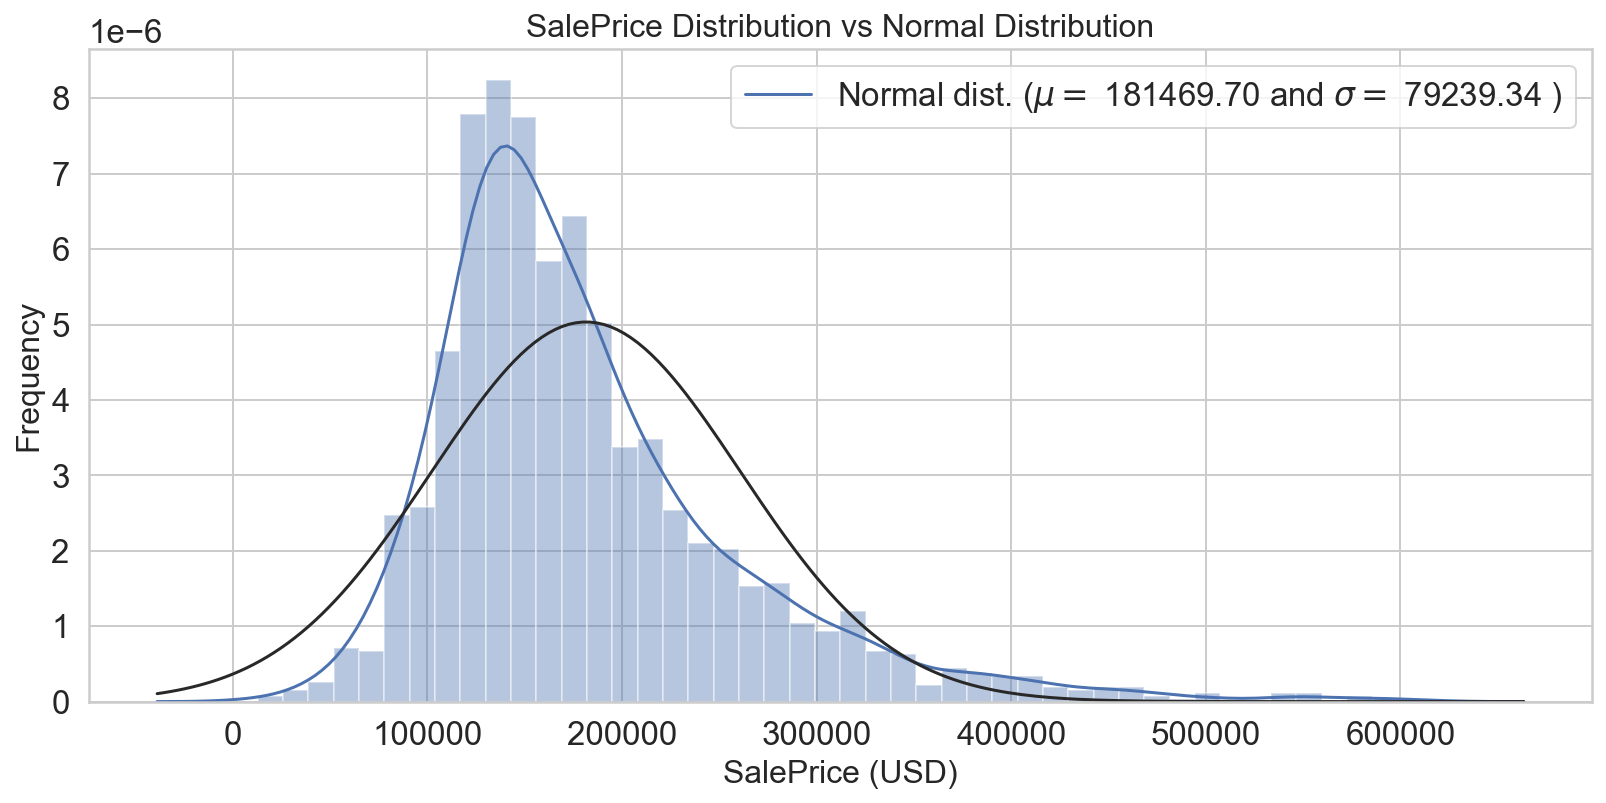

In [10]:
# comparing distribution of SalePrice against normal distribution
(mu, sigma) = norm.fit(df_train['SalePrice'])

plt.figure(figsize = (12,6))
sns.distplot(df_train['SalePrice'], kde = True, hist=True, fit = norm)
plt.title('SalePrice Distribution vs Normal Distribution', fontsize = 16)
plt.xlabel("SalePrice (USD)", fontsize = 16)
plt.ylabel("Frequency", fontsize = 16)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.show()
# print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

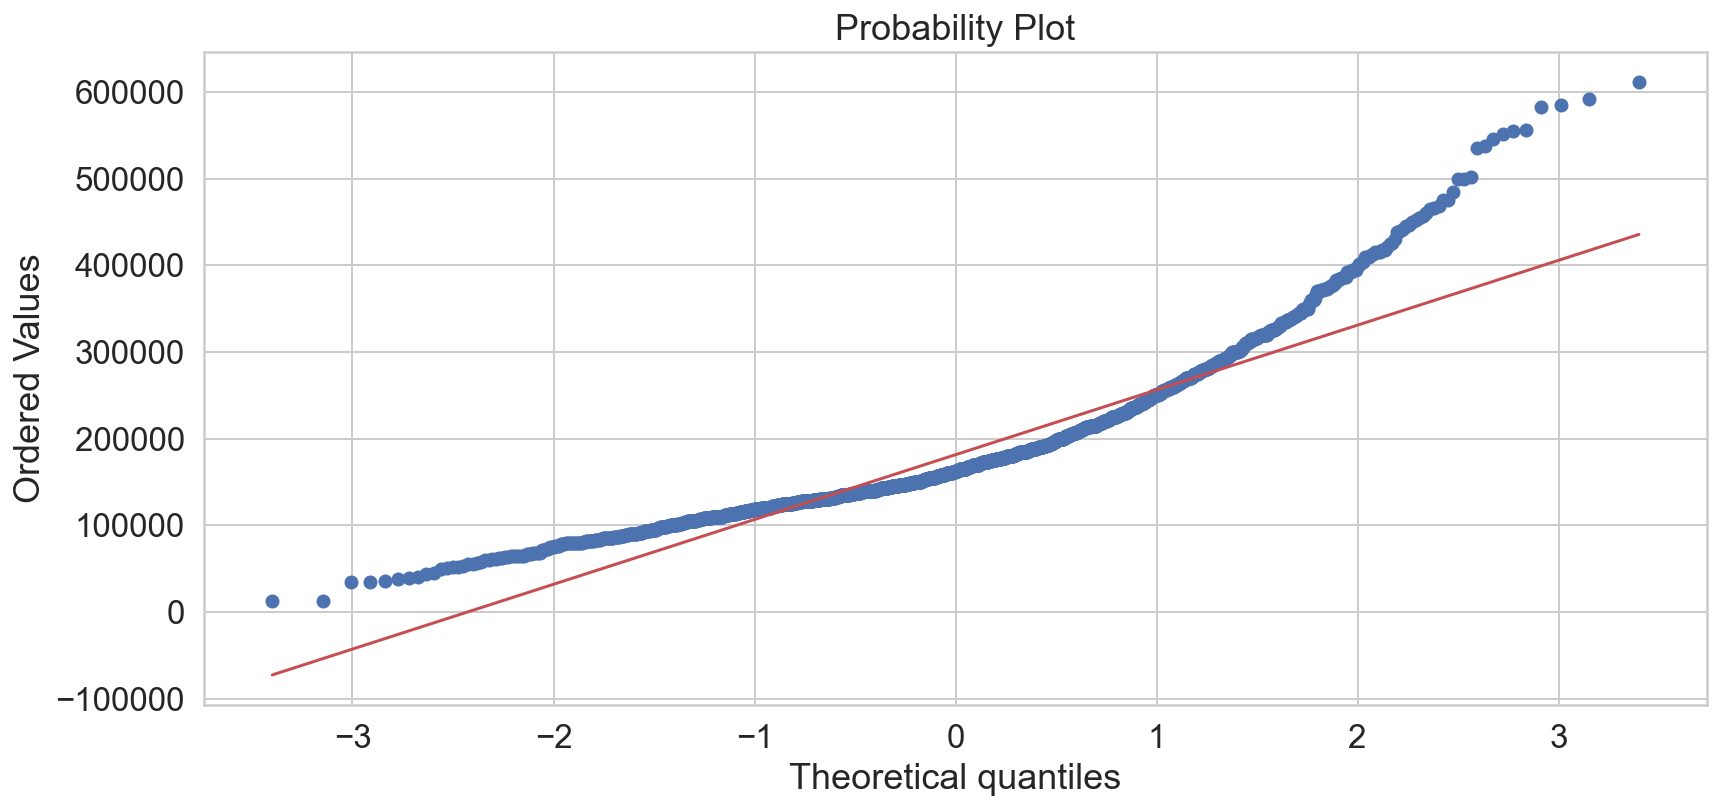

In [11]:
# QQ-plot
plt.figure(figsize = (12,6))
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()

In [12]:
# skewness and kurtosis
print(f"Skewness: {df_train['SalePrice'].skew()}")
print(f"Kurtosis: {df_train['SalePrice'].kurt()}")

Skewness: 1.5575514385863427
Kurtosis: 3.579003386146362


We can see that the distribution of the house prices is highly positively skewed (skewness = 1.56) with a high kurtosis (kurtosis = 3.58). Together with the distribution histogram and descriptive statistics, they show that we will need to 1) adjust for outliers and 2) transform the variable to be more normally-distributed before performing regression.

## Outlier Treatment

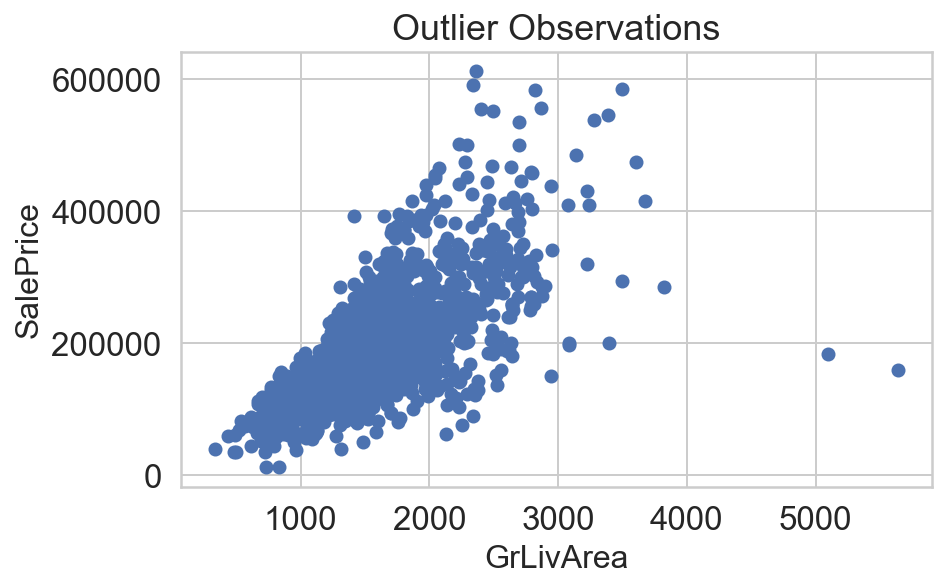

In [13]:
# outliers are discussed in https://ww2.amstat.org/publications/jse/v19n3/decock.pdf
# scatterplot of SalePrice
fig, ax = plt.subplots()
ax.scatter(x = df_train['GrLivArea'], y = df_train['SalePrice'])
plt.title("Outlier Observations")
plt.ylabel('SalePrice', fontsize=16)
plt.xlabel('GrLivArea', fontsize=16)
plt.show()

The author of the dataset recommended plotting Sale Price against Ground Living Area to derive three true outliers (Partial Sales that likely do not represent market values) and two unusual sales (very large houses priced relatively appropriately). He further recommended that removing houses with Ground Living Area of more than 4000 square feet would eliminate these abnormal observations (see [*De Cock (2011)*](http://jse.amstat.org/v19n3/decock.pdf)). 

As these recommendations have shown to be true in the form of the 2 extereme outliers at the bottom right of the scatterplot above, we will go ahead and remove entries for GrLivArea that are more than 4000 square feet.

In [14]:
# removing the outliers of large houses sold at very low prices
df_train = df_train[df_train.GrLivArea < 4000]

### Correcting Skewness of SalePrice

In [15]:
# log transform SalePrice to correct skew
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])
lg_train = df_train.SalePrice
print(lg_train.head())

0    11.779136
1    12.301387
2    11.599112
3    12.066816
4    11.838633
Name: SalePrice, dtype: float64


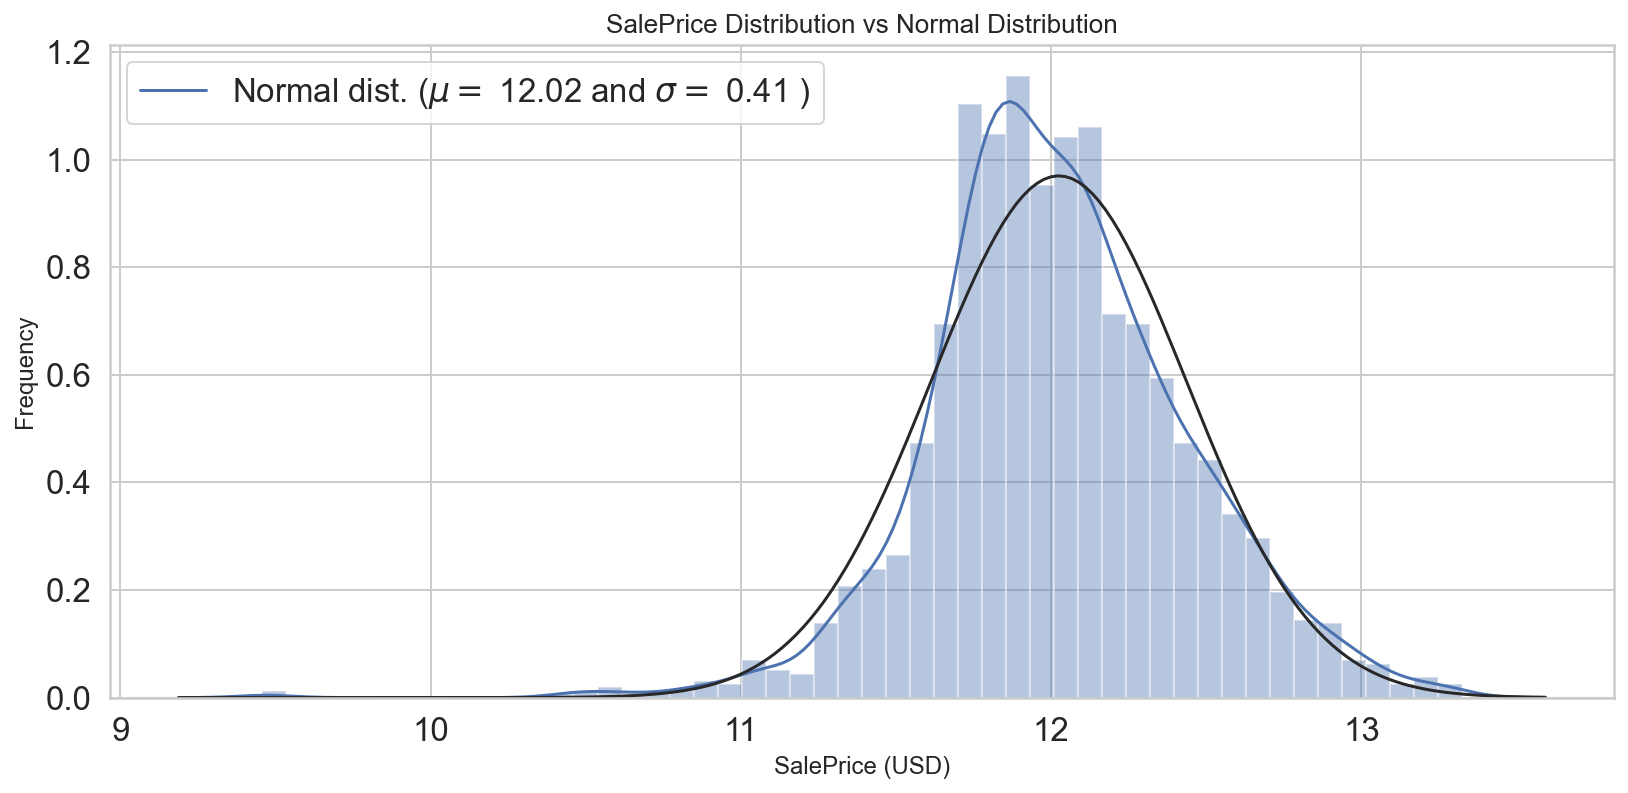

In [16]:
# corrected SalePrice distribution
(mu, sigma) = norm.fit(df_train['SalePrice'])

plt.figure(figsize = (12,6))
sns.distplot(df_train['SalePrice'], kde = True, hist=True, fit = norm)
plt.title('SalePrice Distribution vs Normal Distribution', fontsize = 13)
plt.xlabel("SalePrice (USD)", fontsize = 12)
plt.ylabel("Frequency", fontsize = 12)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.show()

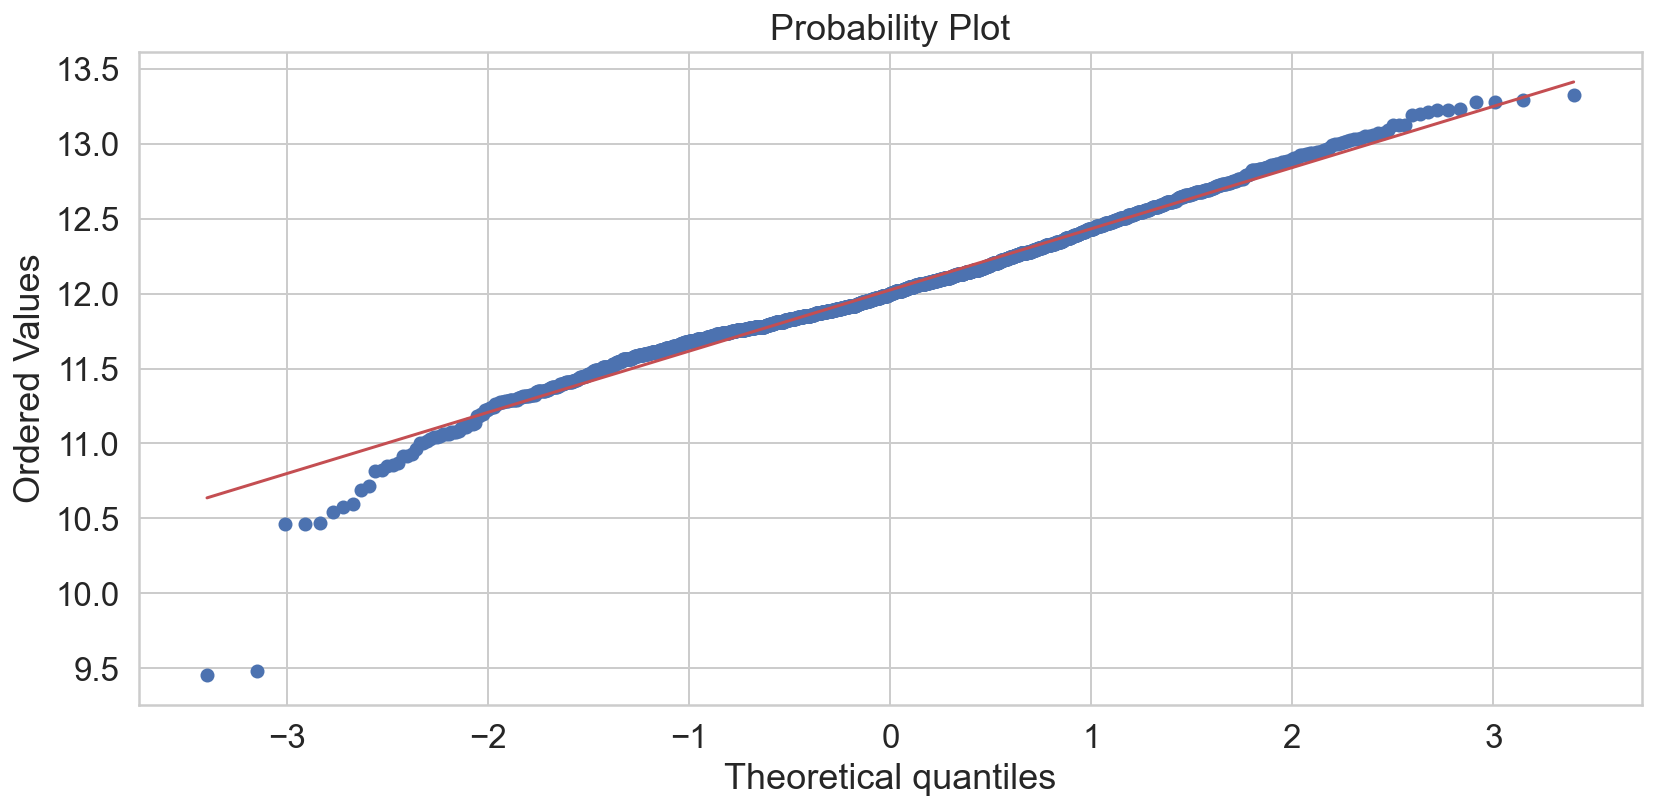

In [17]:
# corrected QQ-plot
fig = plt.figure(figsize = (12,6))
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()

The Sale Price variable looks more normally distributed after adjusting for outliers and undergoing logarithmic transformation transform. 

Our dependent variable is ready for regression modelling!

## Independent variables

In [18]:
# show non-null count and dtype
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2049 non-null   int64  
 1   PID            2049 non-null   int64  
 2   MSSubClass     2049 non-null   int64  
 3   MSZoning       2049 non-null   object 
 4   LotFrontage    1719 non-null   float64
 5   LotArea        2049 non-null   int64  
 6   Street         2049 non-null   object 
 7   Alley          140 non-null    object 
 8   LotShape       2049 non-null   object 
 9   LandContour    2049 non-null   object 
 10  Utilities      2049 non-null   object 
 11  LotConfig      2049 non-null   object 
 12  LandSlope      2049 non-null   object 
 13  Neighborhood   2049 non-null   object 
 14  Condition1     2049 non-null   object 
 15  Condition2     2049 non-null   object 
 16  BldgType       2049 non-null   object 
 17  HouseStyle     2049 non-null   object 
 18  OverallQ

In [19]:
# we seem to have quite a large number of string variables
# show dtype that are not int or float
df_train.dtypes[df_train.dtypes != 'int64'][df_train.dtypes != 'float64']

MSZoning        object
Street          object
Alley           object
LotShape        object
LandContour     object
Utilities       object
LotConfig       object
LandSlope       object
Neighborhood    object
Condition1      object
Condition2      object
BldgType        object
HouseStyle      object
RoofStyle       object
RoofMatl        object
Exterior1st     object
Exterior2nd     object
MasVnrType      object
ExterQual       object
ExterCond       object
Foundation      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Heating         object
HeatingQC       object
CentralAir      object
Electrical      object
KitchenQual     object
Functional      object
FireplaceQu     object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
PavedDrive      object
PoolQC          object
Fence           object
MiscFeature     object
SaleType        object
dtype: object

## Missing values

In [20]:
# list of null values
df_train.isnull().sum().sort_values(ascending=False).head(35)

PoolQC          2041
MiscFeature     1985
Alley           1909
Fence           1649
FireplaceQu     1000
LotFrontage      330
GarageFinish     114
GarageQual       114
GarageYrBlt      114
GarageCond       114
GarageType       113
BsmtExposure      58
BsmtFinType2      56
BsmtFinType1      55
BsmtCond          55
BsmtQual          55
MasVnrArea        22
MasVnrType        22
BsmtHalfBath       2
BsmtFullBath       2
GarageArea         1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
GarageCars         1
MoSold             0
SaleType           0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
KitchenQual        0
YrSold             0
MiscVal            0
dtype: int64

Upon further investigation, some missing categorical values are actually 0-values in ranked categorical variables, and so will need to be encoded in.

## Variable Encoding

In [21]:
# from data description, categorical NA = no such feature (train data)
df_train.loc[:, "Alley"] = df_train.loc[:, "Alley"].fillna("NA")
df_train.loc[:, "Exterior2nd"] = df_train.loc[:, "Alley"].fillna("NA")
df_train.loc[:, "MasVnrType"] = df_train.loc[:, "MasVnrType"].fillna("None")
df_train.loc[:, "BsmtExposure"] = df_train.loc[:, "BsmtExposure"].fillna("NA")
df_train.loc[:, "BsmtCond"] = df_train.loc[:, "BsmtCond"].fillna("NA")
df_train.loc[:, "BsmtFinType1"] = df_train.loc[:, "BsmtFinType1"].fillna("NA")
df_train.loc[:, "BsmtFinType2"] = df_train.loc[:, "BsmtFinType2"].fillna("NA")
df_train.loc[:, "BsmtQual"] = df_train.loc[:, "BsmtQual"].fillna("NA")
df_train.loc[:, "FireplaceQu"] = df_train.loc[:, "FireplaceQu"].fillna("NA")
df_train.loc[:, "GarageType"] = df_train.loc[:, "GarageType"].fillna("NA")
df_train.loc[:, "GarageFinish"] = df_train.loc[:, "GarageFinish"].fillna("NA")
df_train.loc[:, "GarageQual"] = df_train.loc[:, "GarageQual"].fillna("NA")
df_train.loc[:, "GarageCond"] = df_train.loc[:, "GarageCond"].fillna("NA")
df_train.loc[:, "PoolQC"] = df_train.loc[:, "PoolQC"].fillna("NA")
df_train.loc[:, "Fence"] = df_train.loc[:, "Fence"].fillna("NA")
df_train.loc[:, "MiscFeature"] = df_train.loc[:, "MiscFeature"].fillna("NA")

# assumption that null data is absence of area of property connected to street
df_train.loc[:, "LotFrontage"] = df_train.loc[:, "LotFrontage"].fillna(0)

# assumption that null data is absence of masonry veneer
df_train.loc[:, "MasVnrArea"] = df_train.loc[:, "MasVnrArea"].fillna(0)

# assumption that null data is absence of garage
df_train.loc[:, "GarageYrBlt"] = df_train.loc[:, "GarageYrBlt"].fillna(0)

# assumption that null data is absence of basement
df_train.loc[:, "BsmtFullBath"] = df_train.loc[:, "BsmtFullBath"].fillna(0)
df_train.loc[:, "BsmtHalfBath"] = df_train.loc[:, "BsmtHalfBath"].fillna(0)
df_train.loc[:, "TotalBsmtSF"] = df_train.loc[:, "TotalBsmtSF"].fillna(0)
df_train.loc[:, "BsmtUnfSF"] = df_train.loc[:, "BsmtUnfSF"].fillna(0)
df_train.loc[:, "BsmtFinSF2"] = df_train.loc[:, "BsmtFinSF2"].fillna(0)
df_train.loc[:, "BsmtFinSF1"] = df_train.loc[:, "BsmtFinSF1"].fillna(0)

In [22]:
# transform all categorical variables to numerical for correlation analysis using integer coding
intcode_train = df_train.replace({
    "MSZoning" : 
        {'A' : 1, 
         'C' : 2, 
         'FV' : 3, 
         'I' : 4, 
         'RH' : 5,
         'RL' : 6,
         'RP' : 7,
         'RM' : 8},
    "Street" : 
        {'Grvl' : 1, 
         'Pave' : 2},
    "Alley" : 
        {'NA' : 0,    # no alley access
         'Grvl' : 1, 
         'Pave' : 2},
    "LotShape" : 
        {'IR1' : 1, 
         'IR2' : 2, 
         'IR3' : 3, 
         'Reg' : 4},
    "LandContour" :
        {'Low':1, 
         'HLS':4, 
         'Bnk':3, 
         'Lvl':2},
    "Utilities" :
        {'ELO':1, 
         'NoSeWa':2, 
         'NoSewr':3, 
         'AllPub':4}, 
    "LotConfig" :
        {'Inside':1, 
         'Corner':2, 
         'CulDSac':3, 
         'FR2':4,
         'FR3':5},  
    "LandSlope" : 
        {'Sev' : 3, 
         'Mod' : 2, 
         'Gtl' : 1},
    "Neighborhood" : 
        {'Blmngtn' : 1, 
         'Blueste' : 2, 
         'BrDale': 3, 
         'BrkSide': 4, 
         'ClearCr': 5, 
         'CollgCr': 6, 
         'Crawfor': 7, 
         'Edwards': 8, 
         'Gilbert': 9, 
         'Greens': 10, 
         'GrnHill': 11, 
         'IDOTRR': 12,
         'Landmrk': 13,
         'MeadowV': 14,
         'Mitchel': 15,
         'Names': 16,
         'NoRidge': 17,
         'NPkVill': 18,
         'NridgHt': 19,
         'NAmes': 20,
         'OldTown': 21,
         'SWISU': 22,
         'Sawyer': 23,
         'SawyerW': 24,
         'Somerst': 25,
         'StoneBr': 26,
         'Timber': 27,         
         'Veenker' : 28},    
     "Condition1" : 
        {'Artery' : 1, 
         'Feedr' : 2, 
         'Norm': 3, 
         'RRNn': 4, 
         'RRAn': 5, 
         'PosN': 6, 
         'PosA': 7, 
         'RRNe': 8, 
         'RRAe': 9},
     "Condition2" : 
        {'Artery' : 1, 
         'Feedr' : 2, 
         'Norm': 3, 
         'RRNn': 4, 
         'RRAn': 5, 
         'PosN': 6, 
         'PosA': 7, 
         'RRNe': 8, 
         'RRAe': 9},
    "BldgType" : 
        {'1Fam' : 1, 
         '2FmCon' : 2, 
         'Duplx' : 3, 
         'TwnhsE' : 4,
         'TwnhsI' : 5},    
     "HouseStyle" : 
        {'1Story' : 1, 
         '1.5Fin' : 2, 
         '1.5Unf': 3, 
         '2Story': 4, 
         '2.5Fin': 5, 
         '2.5Unf': 6, 
         'SFoyer': 7, 
         'SLvl': 8},
    "RoofStyle" : 
        {'Flat' : 1, 
         'Gable' : 2, 
         'Gambrel' : 3, 
         'Hip' : 4,
         'Mansard' : 5,
         'Shed' : 6},  
     "RoofMatl" : 
        {'ClyTile' : 1, 
         'CompShg' : 2, 
         'Membran': 3, 
         'Metal': 4, 
         'Roll': 5, 
         'Tar&Grv': 6, 
         'WdShake': 7, 
         'WdShngl': 8},
     "Exterior1st" : 
        {'AsbShng' : 1, 
         'AsphShn' : 2, 
         'BrkComm': 3, 
         'BrkFace': 4, 
         'CBlock': 5, 
         'CemntBd': 6, 
         'HdBoard': 7, 
         'ImStucc': 8, 
         'MetalSd': 9, 
         'Other': 10, 
         'Plywood': 11, 
         'PreCast': 12, 
         'Stone': 13, 
         'Stucco': 14, 
         'VinylSd': 15, 
         'Wd Sdng': 16, 
         'WdShing': 17},    
     "Exterior2nd" : 
        {'NA' : 0,     # if second material not applicable
         'AsbShng' : 1, 
         'AsphShn' : 2, 
         'BrkComm': 3, 
         'BrkFace': 4, 
         'CBlock': 5, 
         'CemntBd': 6, 
         'HdBoard': 7, 
         'ImStucc': 8, 
         'MetalSd': 9, 
         'Other': 10, 
         'Plywood': 11, 
         'PreCast': 12, 
         'Stone': 13, 
         'Stucco': 14, 
         'VinylSd': 15, 
         'Wd Sdng': 16, 
         'WdShing': 17},  
    "MasVnrType" : 
        {'None' : 0,    # no masonry veneer area
         'BrkCmn' : 1, 
         'BrkFace': 2, 
         'CBlock': 3, 
         'Stone' : 4},    
    "ExterQual" : 
        {'Po' : 1, 
         'Fa' : 2, 
         'TA': 3, 
         'Gd': 4, 
         'Ex' : 5},
    "ExterCond" : 
        {'Po' : 1, 
         'Fa' : 2, 
         'TA': 3, 
         'Gd': 4, 
         'Ex' : 5},
    "Foundation" : 
        {'BrkTil' : 1, 
         'CBlock' : 2, 
         'PConc' : 3, 
         'Slab' : 4,
         'Stone' : 4,
         'Wood' : 5},    
    "BsmtCond" : 
        {'NA' : 0,    # no basement 
         'Po' : 1, 
         'Fa' : 2, 
         'TA' : 3, 
         'Gd' : 4,
         'Ex' : 5},
    "BsmtExposure" : 
        {'NA' : 0,    # no basement
         'No' : 0,
         'Mn' : 1, 
         'Av': 2, 
         'Gd' : 3},
    "BsmtFinType1" : 
        {'NA' : 0,    # no basement
         'Unf' : 1, 
         'LwQ': 2, 
         'Rec' : 3, 
         'BLQ' : 4, 
         'ALQ' : 5, 
         'GLQ' : 6},
    "BsmtFinType2" : 
        {'NA' : 0,    # no basement
         'Unf' : 1, 
         'LwQ': 2, 
         'Rec' : 3, 
         'BLQ' : 4, 
         'ALQ' : 5, 
         'GLQ' : 6},
    "BsmtQual" : 
        {'NA' : 0,    # no basement
         'Po' : 1, 
         'Fa' : 2, 
         'TA': 3, 
         'Gd': 4, 
         'Ex' : 5},
    "Heating" : 
        {'Floor' : 1, 
         'GasA' : 2, 
         'GasW': 3, 
         'Grav': 4, 
         'OthW': 4, 
         'Wall' : 5},
    "HeatingQC" : 
        {'Po' : 1, 
         'Fa' : 2, 
         'TA': 3, 
         'Gd': 4, 
         'Ex' : 5},
    "CentralAir" : 
        {'N' : 0, 
         'Y' : 1},
    "Electrical" : 
        {'SBrkr' : 1, 
         'FuseA' : 2, 
         'FuseF': 3, 
         'FuseP': 4, 
         'Mix' : 5},   
    "KitchenQual" : 
        {'Po' : 1, 
         'Fa' : 2, 
         'TA': 3, 
         'Gd': 4, 
         'Ex' : 5},
    "Functional" : 
        {'Typ' : 1, 
         'Min1': 2, 
         'Min2' : 3, 
         'Mod' : 4, 
         'Maj1' : 5, 
         'Maj2' : 6, 
         'Sev' : 7, 
         'Sal' : 8},
    "FireplaceQu" : 
        {'NA' : 0,    # no fireplace
         'Po' : 1, 
         'Fa' : 2, 
         'TA': 3, 
         'Gd': 4, 
         'Ex' : 5},
    "GarageType" : 
        {'NA' : 0,    # no garage
         '2Types' : 1, 
         'Attchd' : 2, 
         'Basment': 3, 
         'BuiltIn': 4, 
         'CarPort': 5, 
         'Detchd' : 6},
    "GarageFinish" : 
        {'NA' : 0,    # no garage
         'Unf' : 1, 
         'RFn' : 2,  
         'Fin' : 3},
    "GarageQual" : 
        {'NA' : 0,    # no garage
         'Po' : 1, 
         'Fa' : 2, 
         'TA': 3, 
         'Gd': 4, 
         'Ex' : 5},
    "GarageCond" : 
        {'NA' : 0,    # no garage
         'Po' : 1, 
         'Fa' : 2, 
         'TA': 3, 
         'Gd': 4, 
         'Ex' : 5},
    "PavedDrive" : 
        {'N' : 1, 
         'P' : 2, 
         'Y' : 3},
    "PoolQC" : 
        {'NA' : 0,    # no pool
         'Fab' : 1, 
         'TA' : 2, 
         'Gd' : 3, 
         'Ex' : 4},
    "Fence" : 
        {'NA' : 0,    # no fence
         'MnWw' : 1, 
         'GdWo' : 2, 
         'MnPrv' : 3, 
         'GdPrv' : 4},
    "MiscFeature" : 
        {'NA' : 0,    # no misc feature
         'Elev' : 1, 
         'Gar2' : 2, 
         'Othr' : 3, 
         'Shed' : 4, 
         'TenC' : 5},
    "SaleType" : 
        {'WD ' : 1, 
         'CWD': 2, 
         'VWD' : 3, 
         'New' : 4, 
         'COD' : 5, 
         'Con' : 6, 
         'ConLw' : 7,
         'ConLI' : 8,
         'ConLD' : 9,
         'Oth' : 10},
    "SaleCondition" : 
        {'Normal' : 1, 
         'Abnorml': 2, 
         'AdjLand' : 3, 
         'Alloca' : 4, 
         'Family' : 5, 
         'Partial' : 6},
        }
)

In [23]:
# check
intcode_train.SaleType.head()

0    1
1    1
2    1
3    1
4    1
Name: SaleType, dtype: int64

In [24]:
# check
intcode_train.head()

Id        PID  MSSubClass MSZoning  LotFrontage  LotArea  Street  Alley  \
0  109  533352170          60        6          0.0    13517       2      0   
1  544  531379050          60        6         43.0    11492       2      0   
2  153  535304180          20        6         68.0     7922       2      0   
3  318  916386060          60        6         73.0     9802       2      0   
4  255  906425045          50        6         82.0    14235       2      0   

   LotShape  LandContour  ...  ScreenPorch  PoolArea  PoolQC Fence  \
0         1            2  ...            0         0       0     0   
1         1            2  ...            0         0       0     0   
2         4            2  ...            0         0       0     0   
3         4            2  ...            0         0       0     0   
4         1            2  ...            0         0       0     0   

   MiscFeature  MiscVal MoSold  YrSold  SaleType  SalePrice  
0            0        0      3    2010         1  11.779136  
1            0        0      4    2009         1  12.301387  
2            0        0      1    2010         1  11.599112  
3            0        0      4    2010         1  12.066816  
4            0        0      3    2010         1  11.838633  

[5 rows x 81 columns]

In [25]:
# columns left with null values in decesding order
intcode_train.isnull().sum().sort_values(ascending=False).head()

GarageCars      1
GarageArea      1
Id              0
BedroomAbvGr    0
FireplaceQu     0
dtype: int64

In [26]:
# show rows with missing data for intcode_train
pd.set_option('display.max_columns', None)
intcode_train[intcode_train.isnull().any(axis=1)]

Id        PID  MSSubClass MSZoning  LotFrontage  LotArea  Street  \
1712  2237  910201180          70        8         50.0     9060       2   

      Alley  LotShape  LandContour  Utilities  LotConfig  LandSlope  \
1712      0         4            2          4          1          1   

     Neighborhood  Condition1  Condition2 BldgType  HouseStyle  OverallQual  \
1712           12           3           3        1           4            5   

      OverallCond  YearBuilt  YearRemod/Add  RoofStyle  RoofMatl  Exterior1st  \
1712            6       1923           1999          2         2           16   

     Exterior2nd  MasVnrType  MasVnrArea  ExterQual  ExterCond  Foundation  \
1712           0           0         0.0          3          3           1   

      BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  \
1712         4         3             0             5       548.0   

      BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  Heating  HeatingQC  \
1712             1         0.0      311.0        859.0        2          5   

      CentralAir  Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  \
1712           1           1       942       886             0       1828   

      BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
1712           0.0           0.0         2         0             3   

      KitchenAbvGr  KitchenQual  TotRmsAbvGrd  Functional  Fireplaces  \
1712             1            4             6           1           0   

      FireplaceQu  GarageType  GarageYrBlt  GarageFinish  GarageCars  \
1712            0           6          0.0             0         NaN   

      GarageArea  GarageQual  GarageCond  PavedDrive  WoodDeckSF  OpenPorchSF  \
1712         NaN           0           0           3         174            0   

      EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea PoolQC  Fence  \
1712            212          0            0         0      0      3   

      MiscFeature  MiscVal  MoSold  YrSold  SaleType  SalePrice  
1712            0        0       3    2007         1  11.924439

In [27]:
df_train.shape

(2049, 81)

In [28]:
# drop row due to inconsistent Garage information and hence cannot assume no garage
intcode_train.dropna(inplace=True)
df_train.dropna(inplace=True)

df_train.shape

(2048, 81)

### Correlation Matrix

In [29]:
# Correlation Matrix

f, ax = plt.subplots(figsize=(100, 100))
mat = intcode_train.corr('pearson')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

The heatmap shows clearly that there are issues with multicollinearity from the red boxes with high correlation coefficients that not on the Sale Price row (bottom row).

In [30]:
# check for multicollinearity
print("Highly correlated feature pairs")
pd.set_option('display.max_rows', None)
intcode_train.corr().unstack().sort_values(ascending=False).drop_duplicates().head(20)

Highly correlated feature pairs


Id            Id              1.000000
GarageYrBlt   GarageCond      0.954533
GarageCond    GarageQual      0.950118
GarageQual    GarageYrBlt     0.947215
GarageCars    GarageArea      0.897057
FireplaceQu   Fireplaces      0.860724
SalePrice     OverallQual     0.825650
GrLivArea     TotRmsAbvGrd    0.812330
TotalBsmtSF   1stFlrSF        0.790222
BsmtFinType2  BsmtFinSF2      0.777751
OverallQual   ExterQual       0.738302
ExterQual     KitchenQual     0.729473
BsmtFinType1  BsmtFinSF1      0.723008
GrLivArea     SalePrice       0.708629
SalePrice     ExterQual       0.692663
KitchenQual   OverallQual     0.689348
YearBuilt     Foundation      0.685982
KitchenQual   SalePrice       0.683256
GarageCars    SalePrice       0.668053
TotRmsAbvGrd  BedroomAbvGr    0.665053
dtype: float64

From the heatmap and list above, we can see instances of multicollinearity (correlation > 0.7) that need to be addressed in order for us to get an accurate model. These are:
- YrSold & ID
- GarageYrBlt & GarageQual & GarageCond
- FireplaceQu & Fireplaces
- GrLivArea & TotRmsAbvGrd    
- 1stFlrSF & TotalBsmtSF
- BsmtFinSF2 & BsmtFinType2
- OverallQual & ExterQual & KitchenQual
- BsmtFinType1 & BsmtFinSF1

In [31]:
# Find most important features relative to target
print("Features highly correlated to SalePrice")
corr = intcode_train.corr()
pd.set_option('display.max_rows', None)
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

Features highly correlated to SalePrice
SalePrice        1.000000
OverallQual      0.825650
GrLivArea        0.708629
ExterQual        0.692663
KitchenQual      0.683256
GarageCars       0.668053
TotalBsmtSF      0.655633
GarageArea       0.655284
BsmtQual         0.642968
1stFlrSF         0.626121
YearBuilt        0.625036
YearRemod/Add    0.599944
GarageFinish     0.598703
FullBath         0.566159
FireplaceQu      0.542394
HeatingQC        0.502276
TotRmsAbvGrd     0.501306
Fireplaces       0.486947
MasVnrArea       0.448303
Foundation       0.445655
MasVnrType       0.437812
BsmtFinSF1       0.429132
PavedDrive       0.393370
CentralAir       0.387087
BsmtFinType1     0.386146
BsmtExposure     0.383583
GarageQual       0.364408
GarageCond       0.352713
OpenPorchSF      0.332247
WoodDeckSF       0.330973
GarageYrBlt      0.329992
HalfBath         0.300652
BsmtCond         0.294357
BsmtFullBath     0.286656
LotArea          0.285639
2ndFlrSF         0.257374
RoofStyle        0.19995

To tackle multicollinearity, we are dropping the following rows: Id, GarageYrBlt, GarageCond, Fireplaces, TotRmsAbvGrd, 1stFlrSF, BsmtFinType2, ExterQual, KitchenQual
- YrSold & ID: drop ID as ID is ordinal
- GarageYrBlt & GarageQual & GarageCond: drop GarageYrBlt & GarageCond as GarageQual has higher correlation value with SalePrice
- FireplaceQu & Fireplaces: drop Fireplaces as FireplaceQu has higher correlation value with SalePrice
- GrLivArea & TotRmsAbvGrd: drop TotRmsAbvGrd as GrLivArea has higher correlation value with SalePrice    
- 1stFlrSF & TotalBsmtSF: drop 1stFlrSF as TotalBsmtSF has higher correlation value with SalePrice     
- BsmtFinSF2 & BsmtFinType2: drop BsmtFinType2 as BsmtFinSF2 has higher correlation value with SalePrice 
- OverallQual & ExterQual & KitchenQual: drop ExterQual & KitchenQual as OverallQual has higher correlation value with SalePrice    
- BsmtFinType1 % BsmtFinSF1 : drop BsmtFinType1 as BsmtFinSF1 has higher correlation value with SalePrice 

In [32]:
intcode_train = intcode_train.drop(columns = ["Id", "GarageYrBlt", "GarageCond", "Fireplaces", "TotRmsAbvGrd", "1stFlrSF", "BsmtFinType2", "ExterQual", "KitchenQual"], axis=1)

In [33]:
intcode_train.to_csv('datasets/intcode_train.csv', index=False)

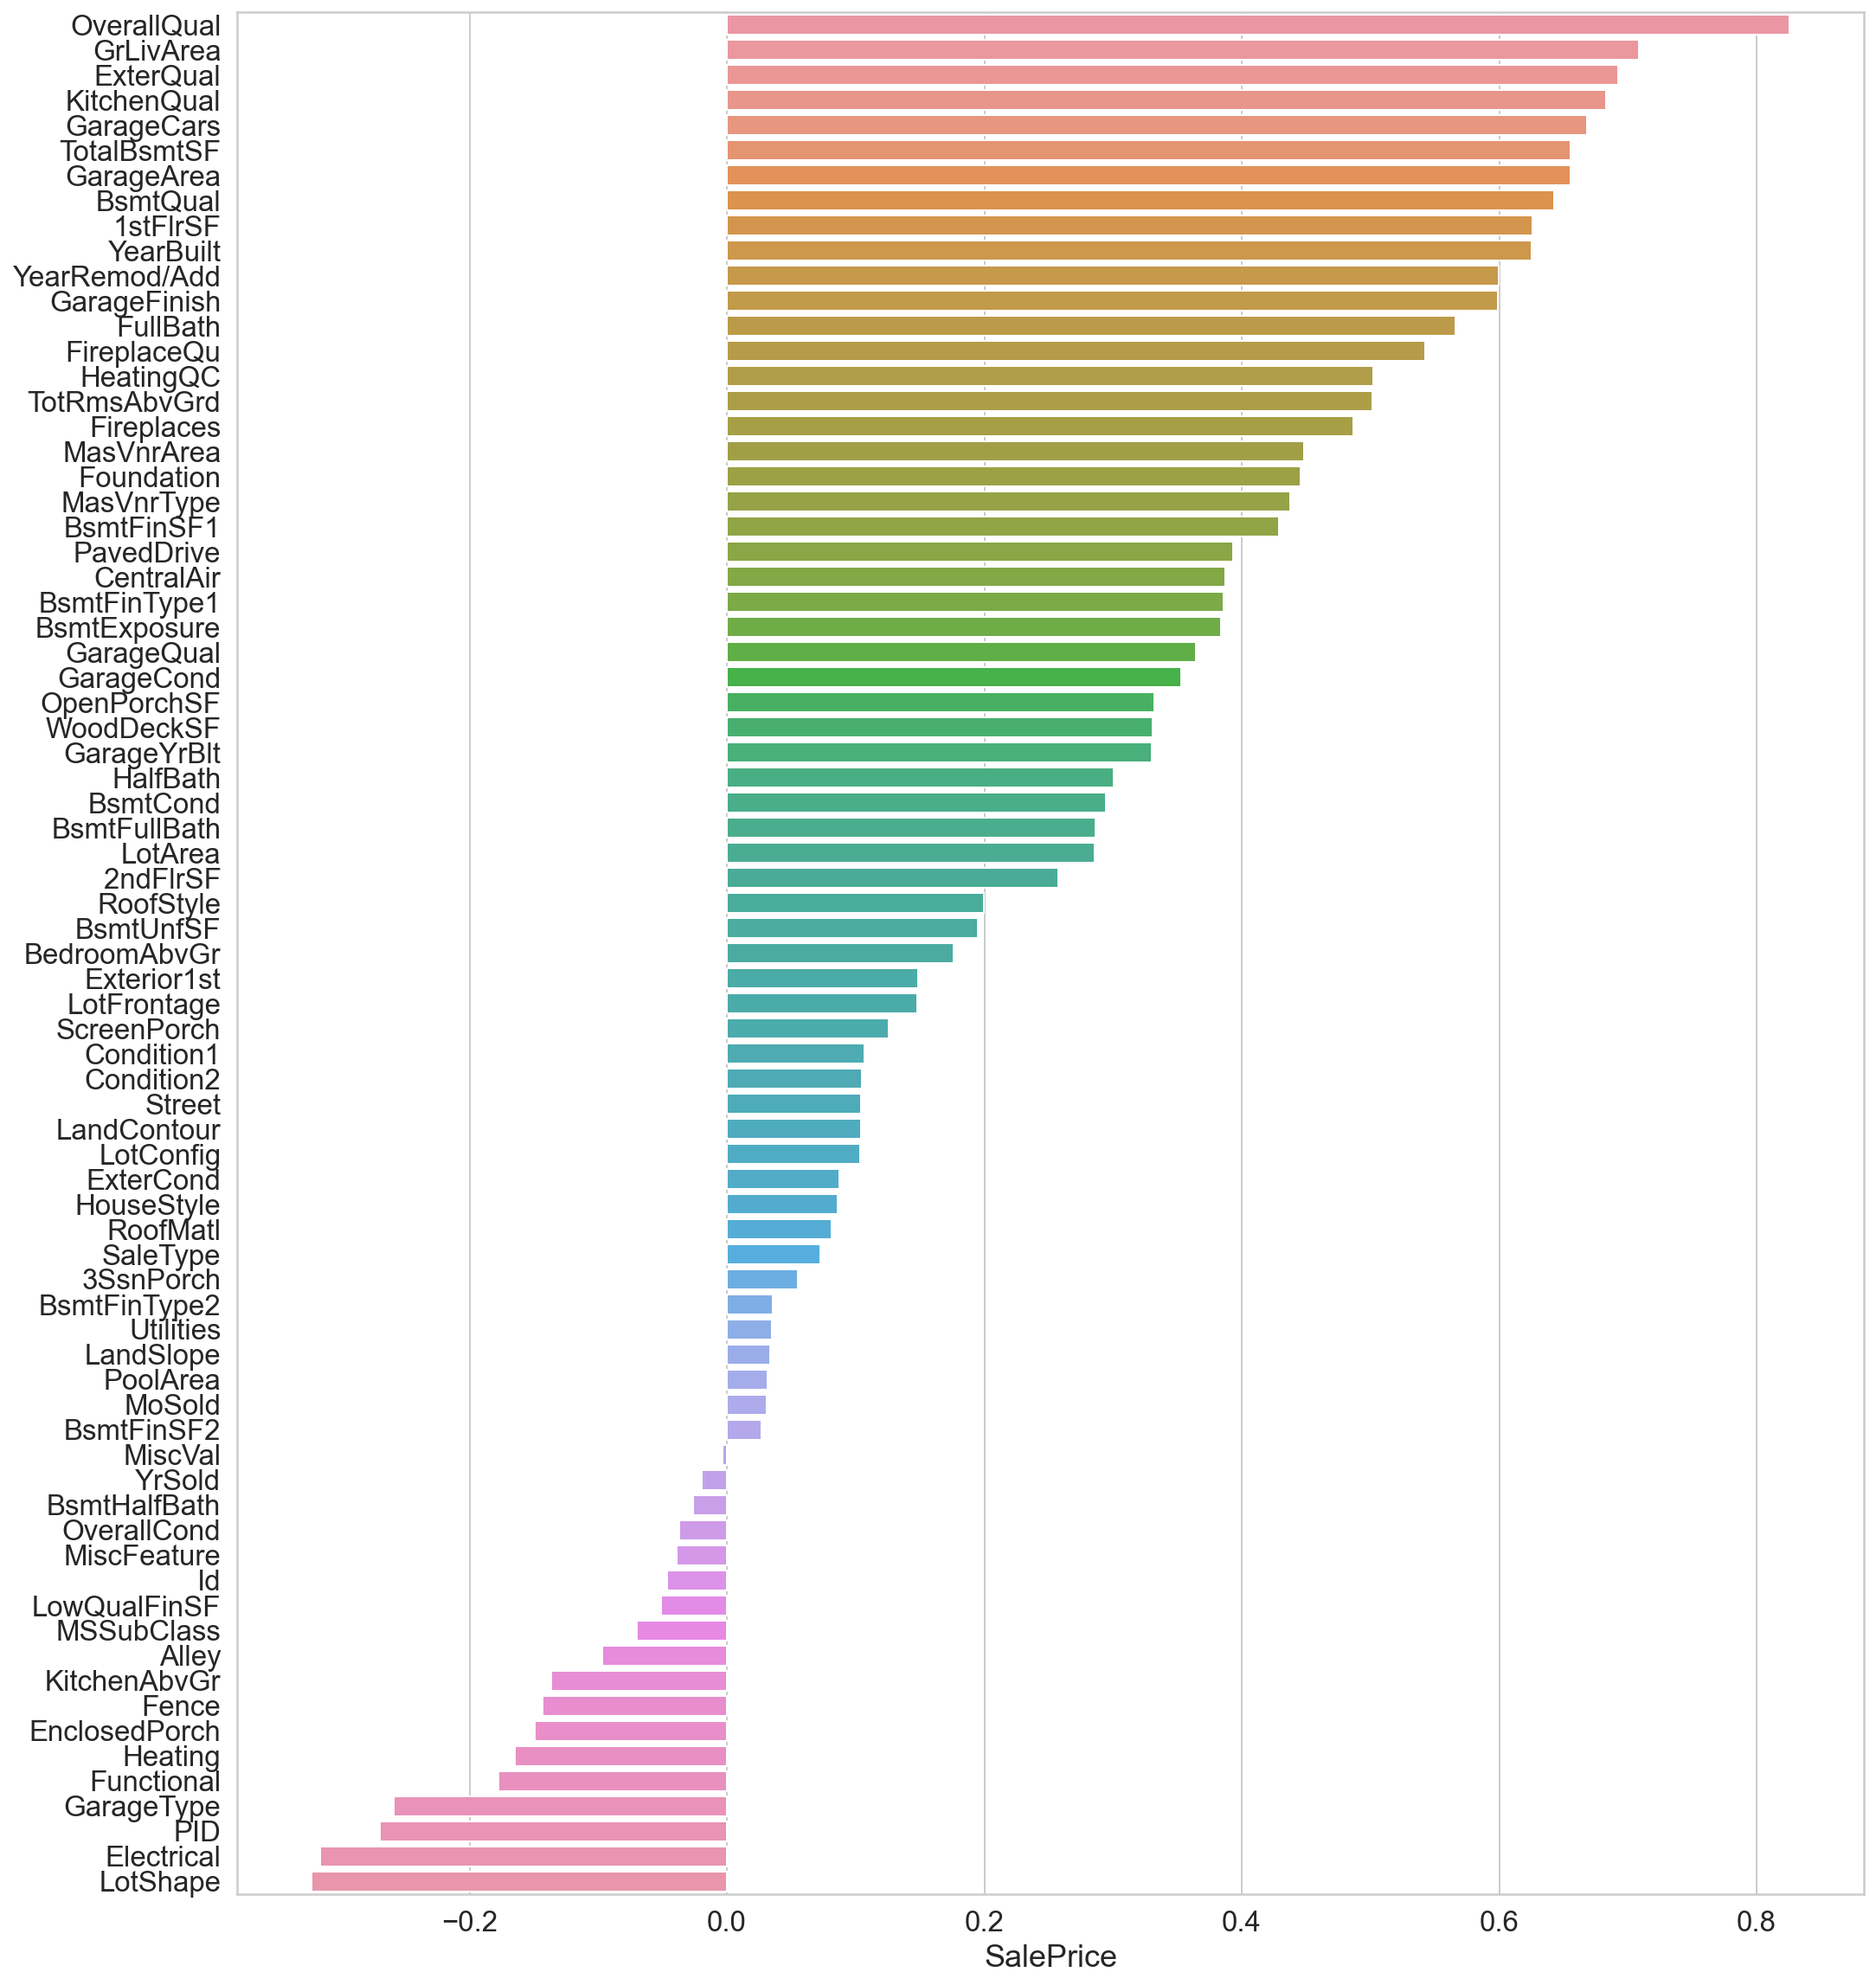

In [34]:
# Feature sorted by correlation to SalePrice, from positive to negative
corr = corr.sort_values('SalePrice', ascending=False)
plt.figure(figsize=(15,20))
sns.barplot(corr.SalePrice[1:], corr.index[1:], orient='h')
plt.show()

The features that are highly correlated to Sale Price (coefficient > 0.5) are:

- OverallQual      (0.825650)
- GrLivArea       (0.708629)
- GarageCars       (0.668053)
- TotalBsmtSF      (0.655633)
- GarageArea       (0.655284)
- BsmtQual         (0.642968)
- YearBuilt        (0.625036)
- YearRemod/Add    (0.599944)
- GarageFinish     (0.598703)
- FullBath         (0.566159)
- FireplaceQu      (0.542394)
- HeatingQC        (0.502276)

In [35]:
# drop less relevant columns 
drop_train = df_train.drop(columns = ["Id", "GarageYrBlt", "GarageCond", "Fireplaces", "TotRmsAbvGrd", "1stFlrSF", "BsmtFinType2", "ExterQual", "KitchenQual"], axis=1)

In [36]:
drop_train.to_csv('datasets/drop_train.csv', index=False)

In [37]:
drop_train.head()

PID  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  533352170          60       RL          0.0    13517   Pave    NA      IR1   
1  531379050          60       RL         43.0    11492   Pave    NA      IR1   
2  535304180          20       RL         68.0     7922   Pave    NA      Reg   
3  916386060          60       RL         73.0     9802   Pave    NA      Reg   
4  906425045          50       RL         82.0    14235   Pave    NA      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub   CulDSac       Gtl       Sawyer       RRAe   
1         Lvl    AllPub   CulDSac       Gtl      SawyerW       Norm   
2         Lvl    AllPub    Inside       Gtl        NAmes       Norm   
3         Lvl    AllPub    Inside       Gtl       Timber       Norm   
4         Lvl    AllPub    Inside       Gtl      SawyerW       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            6            8       1976   
1       Norm     1Fam     2Story            7            5       1996   
2       Norm     1Fam     1Story            5            7       1953   
3       Norm     1Fam     2Story            5            5       2006   
4       Norm     1Fam     1.5Fin            6            8       1900   

   YearRemod/Add RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0           2005     Gable  CompShg     HdBoard          NA    BrkFace   
1           1997     Gable  CompShg     VinylSd          NA    BrkFace   
2           2007     Gable  CompShg     VinylSd          NA       None   
3           2007     Gable  CompShg     VinylSd          NA       None   
4           1993     Gable  CompShg     Wd Sdng          NA       None   

   MasVnrArea ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       289.0        TA     CBlock       TA       TA           No   
1       132.0        TA      PConc       Gd       TA           No   
2         0.0        Gd     CBlock       TA       TA           No   
3         0.0        TA      PConc       Gd       TA           No   
4         0.0        TA      PConc       Fa       Gd           No   

  BsmtFinType1  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating  \
0          GLQ       533.0         0.0      192.0        725.0    GasA   
1          GLQ       637.0         0.0      276.0        913.0    GasA   
2          GLQ       731.0         0.0      326.0       1057.0    GasA   
3          Unf         0.0         0.0      384.0        384.0    GasA   
4          Unf         0.0         0.0      676.0        676.0    GasA   

  HeatingQC CentralAir Electrical  2ndFlrSF  LowQualFinSF  GrLivArea  \
0        Ex          Y      SBrkr       754             0       1479   
1        Ex          Y      SBrkr      1209             0       2122   
2        TA          Y      SBrkr         0             0       1057   
3        Gd          Y      SBrkr       700             0       1444   
4        TA          Y      SBrkr       614             0       1445   

   BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
0           0.0           0.0         2         1             3             1   
1           1.0           0.0         2         1             4             1   
2           1.0           0.0         1         0             3             1   
3           0.0           0.0         2         1             3             1   
4           0.0           0.0         2         0             3             1   

  Functional FireplaceQu GarageType GarageFinish  GarageCars  GarageArea  \
0        Typ          NA     Attchd          RFn         2.0       475.0   
1        Typ          TA     Attchd          RFn         2.0       559.0   
2        Typ          NA     Detchd          Unf         1.0       246.0   
3        Typ          NA    BuiltIn          Fin         2.0       400.0   
4        Typ          NA     Detchd          Unf   

In [38]:
# differentiate numerical features (minus the target) and categorical features
cat_feats = drop_train.select_dtypes(include = ["object"]).columns
num_feats = drop_train.select_dtypes(exclude = ["object"]).columns
num_feats = num_feats.drop("SalePrice")
print("Numerical features : " + str(len(num_feats)))
print("Categorical features : " + str(len(cat_feats)))
train_num = drop_train[num_feats]
train_cat = drop_train[cat_feats]

Numerical features : 33
Categorical features : 38


In [39]:
# numerical features for base model
num_feats

Index(['PID', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemod/Add', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')

In [40]:
# categorical features for base model
cat_feats

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'PavedDrive', 'PoolQC', 'Fence',
       'MiscFeature', 'SaleType'],
      dtype='object')

In [41]:
# dummify categorical fetures
train_cat = pd.get_dummies(train_cat)

In [42]:
# add cat and num features to create X and Y
model_train = pd.concat([train_num, train_cat], axis = 1)
print("Total number of features : " + str(model_train.shape[1]))

Total number of features : 265


In [43]:
model_train.head()

PID  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  \
0  533352170          60          0.0    13517            6            8   
1  531379050          60         43.0    11492            7            5   
2  535304180          20         68.0     7922            5            7   
3  916386060          60         73.0     9802            5            5   
4  906425045          50         82.0    14235            6            8   

   YearBuilt  YearRemod/Add  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
0       1976           2005       289.0       533.0         0.0      192.0   
1       1996           1997       132.0       637.0         0.0      276.0   
2       1953           2007         0.0       731.0         0.0      326.0   
3       2006           2007         0.0         0.0         0.0      384.0   
4       1900           1993         0.0         0.0         0.0      676.0   

   TotalBsmtSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
0        725.0       754             0       1479           0.0           0.0   
1        913.0      1209             0       2122           1.0           0.0   
2       1057.0         0             0       1057           1.0           0.0   
3        384.0       700             0       1444           0.0           0.0   
4        676.0       614             0       1445           0.0           0.0   

   FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  GarageCars  GarageArea  \
0         2         1             3             1         2.0       475.0   
1         2         1             4             1         2.0       559.0   
2         1         0             3             1         1.0       246.0   
3         2         1             3             1         2.0       400.0   
4         2         0             3             1         2.0       484.0   

   WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  \
0           0           44              0          0            0         0   
1           0           74              0          0            0         0   
2           0           52              0          0            0         0   
3         100            0              0          0            0         0   
4           0           59              0          0            0         0   

   MiscVal  MoSold  YrSold  MSZoning_A (agr)  MSZoning_C (all)  MSZoning_FV  \
0        0       3    2010                 0                 0            0   
1        0       4    2009                 0                 0            0   
2        0       1    2010                 0                 0            0   
3        0       4    2010                 0                 0            0   
4        0       3    2010                 0                 0            0   

   MSZoning_I (all)  MSZoning_RH  MSZoning_RL  MSZoning_RM  Street_Grvl  \
0                 0            0            1            0            0   
1                 0            0            1            0            0   
2                 0            0            1            0            0   
3                 0            0            1            0            0   
4                 0            0            1            0            0   

   Street_Pave  Alley_Grvl  Alley_NA  Alley_Pave  LotShape_IR1  LotShape_IR2  \
0            1           0         1           0             1             0   
1            1           0         1           0             1             0   
2            1           0         1           0             0             0   
3            1           0         1           0             0             0   
4            1           0         1           0             1             0   

   LotShape_IR3  LotShape_Reg  LandContour_Bnk  LandContour_HLS  \
0             0             0                0                0   
1             0             0                0                0   
2             0             1                0    

In [44]:
model_train.shape

(2048, 265)

## Base Model: Train-Test Split & Linear Regression

In [45]:
# Split into train and validation sets
X = model_train # cleaned test data without SalePrice
y = drop_train["SalePrice"] # log transformed SalePrice
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=8)

In [46]:
print('Shapes')
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

Shapes
X_train: (1024, 265)
X_test: (1024, 265)
y_train: (1024,)
y_test: (1024,)


In [47]:
# initiate model and fit model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [48]:
# In models where the dependent variable has been log-transformed and the predictors have not, 
# To interpet the amount of change in the original metric of the outcome, we first exponentiate the coefficient of census to obtain eg. exp(0.00055773)=1.000558. 
# To calculate the percent change, we can subtract one from this number and multiply by 100.
# from https://stats.idre.ucla.edu/sas/faq/how-can-i-interpret-log-transformed-variables-in-terms-of-percent-change-in-linear-regression/
baseline_coef = ((np.exp(model.coef_-1))*100).mean()
print(f'Baseline model coefficient mean: {baseline_coef}.')

Baseline model coefficient mean: 36.930075511258956.


For every 1 unit increase in the model predictor, there is an approximately 36.9% in sale price.

In [49]:
# The interpretation of the slope and intercept in a regression change when the predictor (X) is put on a log scale. 
# In this case, the intercept is the expected value of the response when the predictor is 1, 
# and the slope measures the expected change in the response when the predictor increases by a fixed percentage.
# from http://www-stat.wharton.upenn.edu/~stine/stat621/handouts/LogsInRegression.pdf

print(f'Baseline model intercept is: {model.intercept_}.')
# The expected Sale Price is approximately $19.38 when the model predictor (x-value) is 1.

Baseline model intercept is: 19.38053344019247.


In [50]:
# linear regression model coefficient
pd.Series(model.coef_, index=X.columns).head()

PID            1.404712e-10
MSSubClass     2.544598e-04
LotFrontage    1.770747e-04
LotArea        6.004628e-06
OverallQual    6.073191e-02
dtype: float64

In [51]:
# generate predictions
preds = model.predict(X_test)
y[:5], preds[:5]

(0    11.779136
 1    12.301387
 2    11.599112
 3    12.066816
 4    11.838633
 Name: SalePrice, dtype: float64,
 array([12.33166605, 11.80155915, 12.2099201 , 12.13752338, 11.70623384]))

In [52]:
# MSE on the training and testing sets
print(f'MSE on split test set: {mean_squared_error(y_train, model.predict(X_train))}')
print(f'MSE on split train set: {mean_squared_error(y_test, preds)}')

MSE on split test set: 0.010422735835783785
MSE on split train set: 0.014730568529848796


In [53]:
# R^2 on the training and testing sets
print(f'Split test r-squared score: {r2_score(y_train, model.predict(X_train))}')
print(f'Split train r-squared score: {r2_score(y_test, preds)}')

Split test r-squared score: 0.9412680416707541
Split train r-squared score: 0.9085301086794869


In [54]:
# cross-validation score
cross_val_score(model, X_train, y_train).mean()

0.8705729856733455

Based on the MSE, the model is performing similarly on both the testing set and training set, which means that it is likely not overfitting or underfitting the data. 

Based on the R^2, the model is explaining approximately 90-94% if the variance in the Y data.

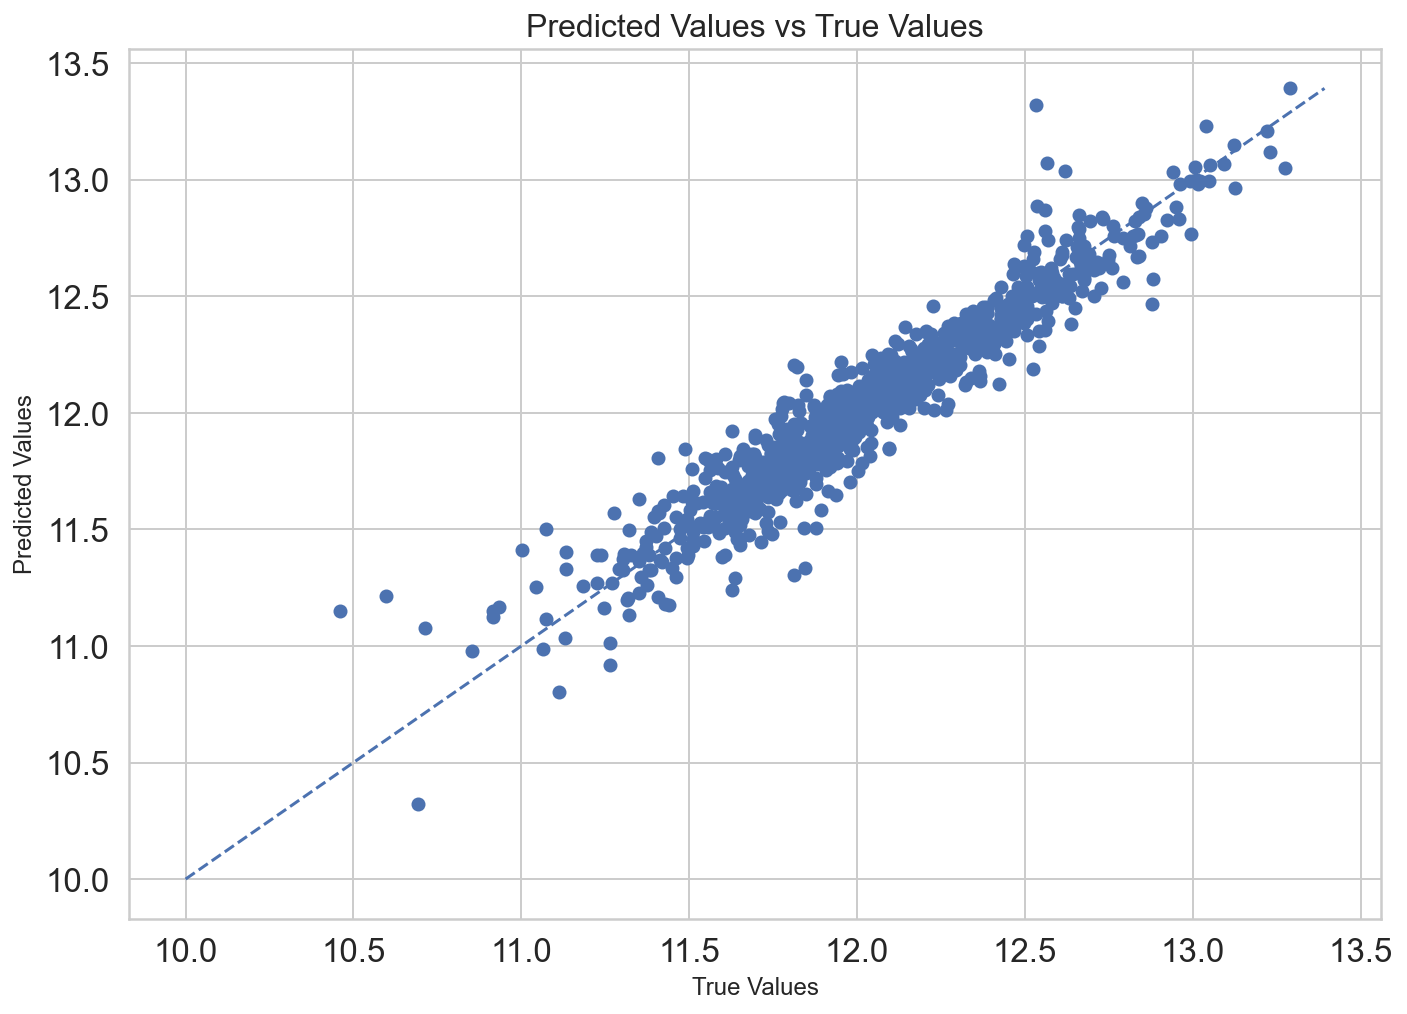

In [55]:
plt.figure(figsize = (10, 8))

# Examine the relationship between observed and predicted values.
plt.scatter(y_test, preds)

# Line showing perfect predictions.
plt.plot([10, max(max(y_test),max(preds))],
         [10, max(max(y_test),max(preds))],
         linestyle = '--')

plt.title('Predicted Values vs True Values', fontsize = 16)
plt.xlabel('True Values', fontsize = 12)
plt.ylabel('Predicted Values', fontsize = 12);

The predicted values occur close to the predicted values linear line. This means our model is looking promising.

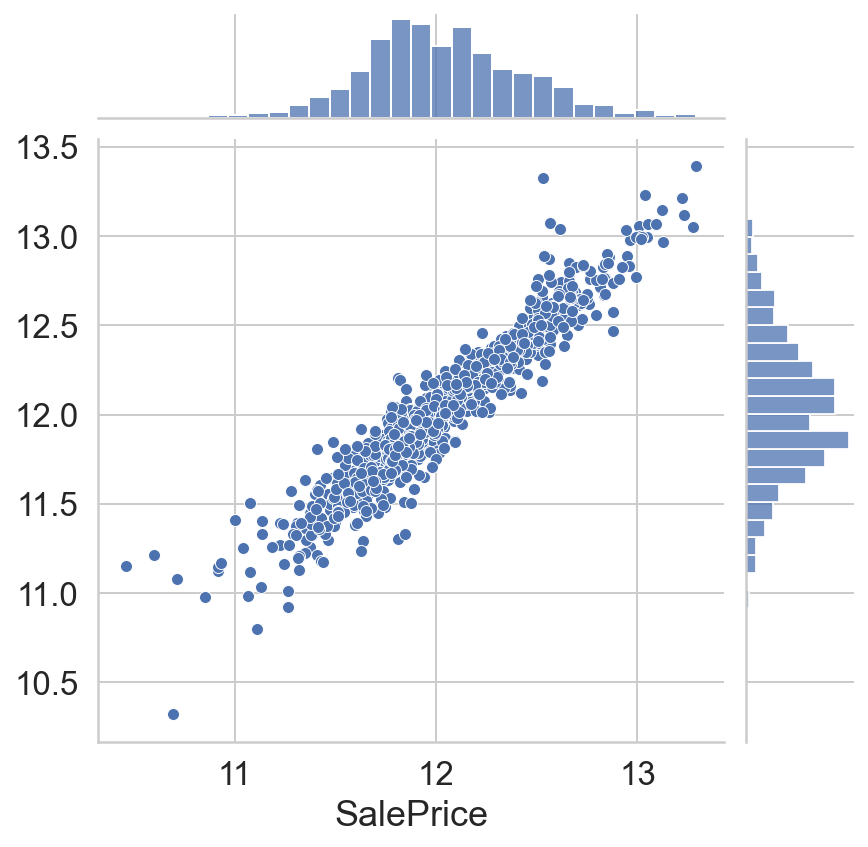

In [56]:
yhat = model.predict(X_test)
sns.jointplot(y_test, yhat)

From the plot above, we can see that the dependent value of Sale Price also mostly occur in the same range as most of the feature coefficients.

In [57]:
print(f'R^2 of baseline linear model (not regularised): {r2_score(y_test, [np.mean(y_train)] * len(y_test))}')

R^2 of baseline linear model (not regularised): -0.002006320710509879


In [58]:
print(f'MSE of baseline linear model (not regularised): {mean_squared_error(y_test, [np.mean(y_train)] * len(y_test))}')

MSE of baseline linear model (not regularised): 0.16136591572901215


## Model Optimisation

### Regularised Model - Ridge Regression (L1)

In [59]:
ridgeRegressor = Ridge()
ridgeRegressor.fit(X_train, y_train)
ridge_pred = ridgeRegressor.predict(X_test)
R_squared = r2_score(ridge_pred, y_test)
print('Test R-squared score :', R_squared)
print(f'MSE of Ridge model: {mean_squared_error(ridge_pred, [np.mean(y_train)] * len(y_test))}')

Test R-squared score : 0.911350028811619
MSE of Ridge model: 0.15673159942923695


In [60]:
# R^2 on the training and testing sets
print(f'Split test r-squared score: {r2_score(y_train, ridgeRegressor.predict(X_train))}')
print(f'Split train r-squared score: {r2_score(y_test, ridge_pred)}')

Split test r-squared score: 0.9396366373984733
Split train r-squared score: 0.9138454820286512


In [61]:
# MSE on the training and testing sets
print(f'MSE on split test set: {mean_squared_error(y_train, ridgeRegressor.predict(X_train))}')
print(f'MSE on split train set: {mean_squared_error(y_test, ridge_pred)}')

MSE on split test set: 0.010712249352020243
MSE on split train set: 0.013874565857808474


In [62]:
# cross-validation score
cross_val_score(ridgeRegressor, X_train, y_train).mean()

0.8867209050609391

Ridge Regularization has reduced the coefficient values from what has been observed in Linear Regression.

In [63]:
# create df for storing names and coefficient values of independent variables
coefficient_df = pd.DataFrame()
coefficient_df['Column_Name'] = X_train.columns

# list % contribution to each unit of sale price increase in decesnding order
rr_coef = (np.exp(ridgeRegressor.coef_-1)*100)
coefficient_df['Coefficient_Value'] = pd.Series(ridgeRegressor.coef_)
rr_coef_list = coefficient_df.sort_values('Coefficient_Value', ascending=False)
print(rr_coef_list)

              Column_Name  Coefficient_Value
74   Neighborhood_GrnHill       1.669748e-01
214        Functional_Typ       1.471167e-01
191          Heating_GasW       1.335950e-01
210       Functional_Min2       1.213137e-01
176           BsmtCond_Po       1.052918e-01
263          SaleType_Oth       1.022266e-01
37            MSZoning_RH       1.001921e-01
209       Functional_Min1       9.931957e-02
211        Functional_Mod       9.418457e-02
35            MSZoning_FV       9.385821e-02
83   Neighborhood_NridgHt       9.243472e-02
136   Exterior1st_BrkFace       9.024442e-02
89   Neighborhood_StoneBr       8.529969e-02
190          Heating_GasA       7.922049e-02
232         GarageQual_Ex       7.864727e-02
196          HeatingQC_Fa       7.430234e-02
96        Condition1_PosN       7.121287e-02
41            Street_Pave       7.010802e-02
159          ExterCond_TA       6.848439e-02
125         RoofStyle_Hip       6.765634e-02
155          ExterCond_Ex       6.555075e-02
63        

<BarContainer object of 265 artists>

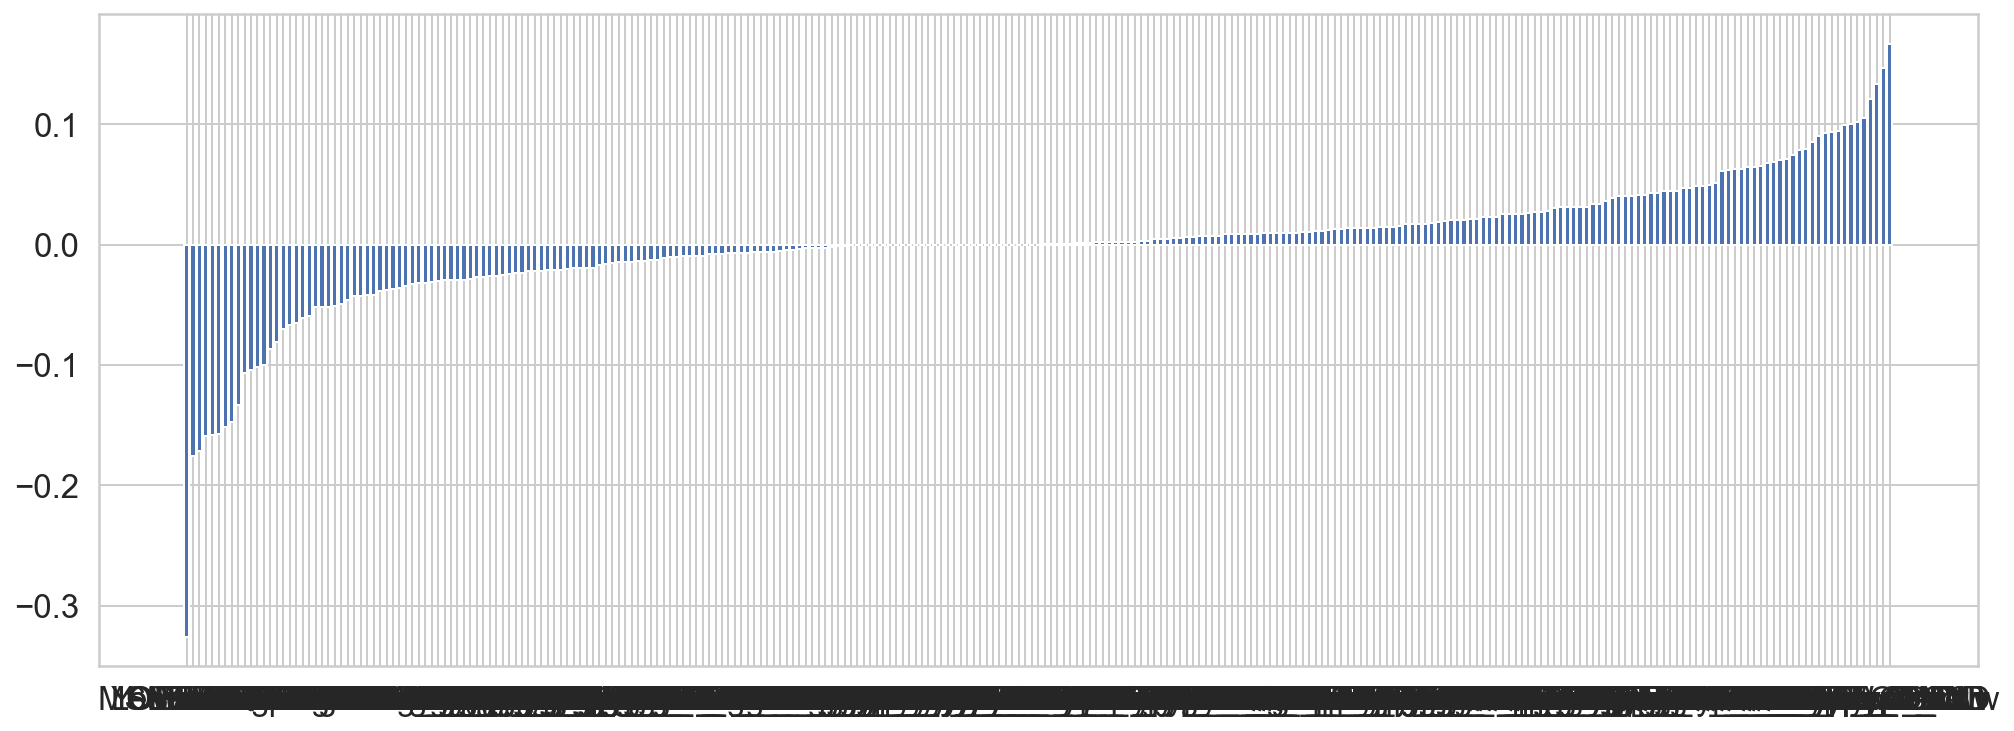

In [64]:
# Plot the coefficent values
plt.rcParams['figure.figsize'] = (15,6)
plt.bar(coefficient_df["Column_Name"], coefficient_df['Coefficient_Value'].sort_values())

Based on Ridge Regression model coefficients, 'Neighborhood_GrnHill', 'Functional_Typ', 'Heating_GasW', 'Functional_Min2', 'BsmtCond_Po', 'SaleType_Oth have a more significant positive impact on the model while 'Foundation_Slab', 'Condition2_Artery', 'Neighborhood_Edwards', 'Functional_Maj2', 'Exterior1st_AsbShng', 'Neighborhood_MeadowV', 'GarageQual_Po', 'RoofStyle_Mansard', 'ExterCond_Po', 'MSZoning_A (agr)', 'Heating_Grav', 'HeatingQC_Po', 'Functional_Sal' have a more negative impact on the model.

## Conclusions and Recommendations

Our Ridge Regression model is an improvement from the baseline linear regression model, having a cross-valuation score of 0.89 as compared to 0.87, with a slight improvement in r-squared score from approximately 90%-94% to 91&-94% in explaining variance.

Based on the MSE, the model is performing similarly on both the testing set and training set, which means that it is likely not overfitting or underfitting the data. Based on the R^2, the model is explaining approximately 91-94% of the variance in the Y data.

Based on exploration of the Ames Housing data and analysis of the predictive model results, we can conclude that houses with the below features have a more significant positive impact on the sale price of houses:
- Located in the neighborhood of GreenHill
- Possess typical functionality or with slight function deduction
- Have hot water or steam heat
- Low basement height of less than 70inches
- Sale types other than warrently deed, home just contructed and sold, contract down pay moment, warranty deed and down payment, new homes constructed and court officer deed.

On the other hand, houses with the below features have a more significant negative impact on the sale price of houses:
- Possess salvage-only home functionality or with major function
- Have poor heating quality
- Have gravel heated
- Located in the agriculture mail service zoning
- Have poor exterior quality with zsbestos xhingles as well as Mansard roof style
- Have poor quality garage
- Located in the Meadow Village or Edwards neighborhood
- Located along adjacent to arterial street

Other than inputting the features of the house of interest into our predictive model and getting a Sale Price based on a more holistic evaluation of its Sale Price, real estate agents can focus on the more significant features and help client to straighten up their houses in hope of scoring a better sale price.

Future improvements to the model can include narrowing down to the important features for training the model and utilising K-Folds cross-validation for the regression. Any new data collected would be used to train the model at regular intervals to ensure that its predictions are up-to-date with the latest real estate trends.